In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
print(os.listdir("../input"))

['cell_images']


In [2]:
import tensorflow as tf
tf.enable_eager_execution()
is_correct_version = '1.13.' in tf.__version__
assert is_correct_version , "Wrong Tensorflow Version [{}]".format(tf.__version__)

is_eager_enabled = tf.executing_eagerly()
assert is_eager_enabled, "Eager mode not activated"

In [3]:
import pathlib
data_root = pathlib.Path("../input/cell_images/cell_images")
print(data_root)
for item in data_root.iterdir():
  print(item)

../input/cell_images/cell_images
../input/cell_images/cell_images/Uninfected
../input/cell_images/cell_images/Parasitized


In [4]:
import random
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths if os.path.splitext(str(path))[1] == '.png']
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
image_count

27558

In [5]:
import os
for file_path in all_image_paths:
    filename, file_extension = os.path.splitext(file_path)
    if file_extension != '.png':
        print('this file : %s',filename)

In [6]:
all_image_paths[:10]

['../input/cell_images/cell_images/Uninfected/C62P23N_ThinF_IMG_20150818_133055_cell_85.png',
 '../input/cell_images/cell_images/Uninfected/C65P26N_ThinF_IMG_20150818_154050_cell_90.png',
 '../input/cell_images/cell_images/Uninfected/C109P70ThinF_IMG_20150930_103811_cell_71.png',
 '../input/cell_images/cell_images/Parasitized/C84P45ThinF_IMG_20150818_103817_cell_6.png',
 '../input/cell_images/cell_images/Uninfected/C225ThinF_IMG_20151112_113836_cell_114.png',
 '../input/cell_images/cell_images/Uninfected/C47P8thinOriginalOlympusCX21_IMG_20150717_174750_cell_14.png',
 '../input/cell_images/cell_images/Uninfected/C235ThinF_IMG_20151112_164834_cell_10.png',
 '../input/cell_images/cell_images/Uninfected/C79P40ThinF_IMG_20150817_102823_cell_4.png',
 '../input/cell_images/cell_images/Uninfected/C48P9thinF_IMG_20150721_160944_cell_161.png',
 '../input/cell_images/cell_images/Uninfected/C65P26N_ThinF_IMG_20150818_154624_cell_88.png']

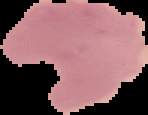

C99P60ThinF_IMG_20150918_141520_cell_124


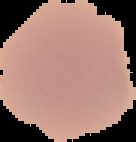

C48P9thinF_IMG_20150721_161055_cell_13


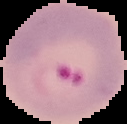

C95P56ThinF_IMG_20150821_172607_cell_96


In [7]:
import IPython.display as display

def caption_image(image_path):
    return image_path.split('/')[-1].split('.')[0]
    
for n in range(3):
  image_path = random.choice(all_image_paths)
  display.display(display.Image(image_path))
  print(caption_image(image_path))

In [8]:
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_names

['Parasitized', 'Uninfected']

In [9]:
label_to_index = dict((name, index) for index,name in enumerate(label_names))
label_to_index

{'Parasitized': 0, 'Uninfected': 1}

In [10]:
all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]

print("First 10 labels indices: ", all_image_labels[:10])

First 10 labels indices:  [1, 1, 1, 0, 1, 1, 1, 1, 1, 1]


In [11]:
img_path = all_image_paths[3]
img_path

'../input/cell_images/cell_images/Parasitized/C84P45ThinF_IMG_20150818_103817_cell_6.png'

In [12]:
img_raw = tf.read_file(img_path)
print(repr(img_raw)[:100]+"...")

<tf.Tensor: id=1, shape=(), dtype=string, numpy=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00\x7...


In [13]:
img_tensor = tf.image.decode_image(img_raw)

print(img_tensor.shape)
print(img_tensor.dtype)

(109, 127, 3)
<dtype: 'uint8'>


In [14]:
img_final = tf.image.resize_images(img_tensor, [192, 192])
img_final = img_final/255.0
print(img_final.shape)
print(img_final.numpy().min())
print(img_final.numpy().max())

(192, 192, 3)
0.0
0.84705883


In [15]:
def preprocess_image(image):
  image = tf.image.decode_png(image, channels=3)
  image = tf.image.resize_images(image, [192, 192])
  image /= 255.0  # normalize to [0,1] range

  return image

def load_and_preprocess_image(path):
  image = tf.read_file(path)
  return preprocess_image(image)

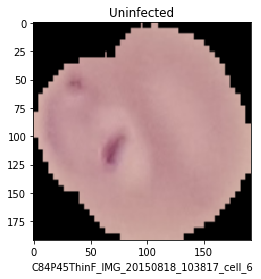

In [16]:
import matplotlib.pyplot as plt

image_path = all_image_paths[0]
label = all_image_labels[0]

plt.imshow(load_and_preprocess_image(img_path))
plt.grid(False)
plt.xlabel(caption_image(img_path))
plt.title(label_names[label].title())
print()

After inspecting the images, let's create the dataset iterator to use the dataset in the neural network.

In [17]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)
print('shape: ', repr(path_ds.output_shapes))
print('type: ', path_ds.output_types)
print()
print(path_ds)

shape:  TensorShape([])
type:  <dtype: 'string'>

<DatasetV1Adapter shapes: (), types: tf.string>


In [18]:
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

Instructions for updating:
Colocations handled automatically by placer.


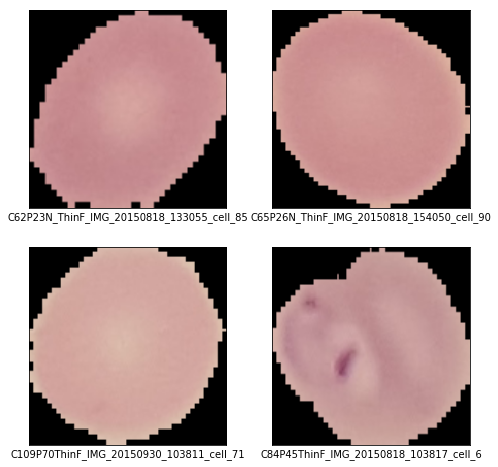

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
for n,image in enumerate(image_ds.take(4)):
  plt.subplot(2,2,n+1)
  plt.imshow(image)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.xlabel(caption_image(all_image_paths[n]))

In [20]:
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels, tf.int64))

In [21]:
for label in label_ds.take(10):
  print(label_names[label.numpy()])

Uninfected
Uninfected
Uninfected
Parasitized
Uninfected
Uninfected
Uninfected
Uninfected
Uninfected
Uninfected


In [22]:
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
print('image shape: ', image_label_ds.output_shapes[0])
print('label shape: ', image_label_ds.output_shapes[1])
print('types: ', image_label_ds.output_types)
print()
print(image_label_ds)

image shape:  (192, 192, 3)
label shape:  ()
types:  (tf.float32, tf.int64)

<DatasetV1Adapter shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int64)>


In [23]:
ds = tf.data.Dataset.from_tensor_slices((all_image_paths, all_image_labels))

# The tuples are unpacked into the positional arguments of the mapped function 
def load_and_preprocess_from_path_label(path, label):
  return load_and_preprocess_image(path), label

image_label_ds = ds.map(load_and_preprocess_from_path_label)
image_label_ds

<DatasetV1Adapter shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int32)>

In [24]:
BATCH_SIZE = 32


ds = image_label_ds.shuffle(buffer_size=image_count)
ds = ds.repeat()
ds = ds.batch(BATCH_SIZE)

ds = ds.prefetch(buffer_size=AUTOTUNE)
ds

<DatasetV1Adapter shapes: ((?, 192, 192, 3), (?,)), types: (tf.float32, tf.int32)>

In [25]:
ds = image_label_ds.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds = ds.batch(BATCH_SIZE)
ds = ds.prefetch(buffer_size=AUTOTUNE)
ds

<DatasetV1Adapter shapes: ((?, 192, 192, 3), (?,)), types: (tf.float32, tf.int32)>

In [26]:
def build_nn_model():
  nn_model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(filters=24, kernel_size=(3,3), input_shape=(28, 28, 1), activation=tf.nn.relu),

      tf.keras.layers.MaxPool2D(pool_size=(2,2)), 

      tf.keras.layers.Conv2D(filters=36, kernel_size=(3,3), input_shape=(13, 13, 1), activation=tf.nn.relu),

      tf.keras.layers.MaxPool2D(pool_size=(2,2)),
      
      tf.keras.layers.Flatten(),
      
      tf.keras.layers.Dense(128, activation=tf.nn.relu),
      
      tf.keras.layers.Dense(10, activation=tf.nn.softmax)
  ])
  return nn_model

model = build_nn_model()

In [27]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [28]:
def change_range(image,label):
  return 2*image-1, label

keras_ds = ds.map(change_range)
keras_ds

<DatasetV1Adapter shapes: ((?, 192, 192, 3), (?,)), types: (tf.float32, tf.int32)>

In [29]:
# The dataset may take a few seconds to start, as it fills its shuffle buffer.
image_batch, label_batch = next(iter(keras_ds))